In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df_single = pd.read_hdf("ec_cc_from_shadows.h5", key="df")
# df_single['ngroup'] = df["shots"]
df_single['energy_ec_mg_single'] = df_single.energy
df_single.dropna(inplace=True)
df_single['Type'] = "Simulation"

In [3]:
df = pd.read_hdf("ec_cc_from_shadows_multi.h5", key="df")
df['ngroup'] = df["shots"]
df['energy_ec_mg'] = df.energy
df['shots'] = df.ngroup * 1000

/tmp/ipykernel_1233374/1981979915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.drop(dff[np.abs(dff.energy) > 1e10].index, inplace=True)


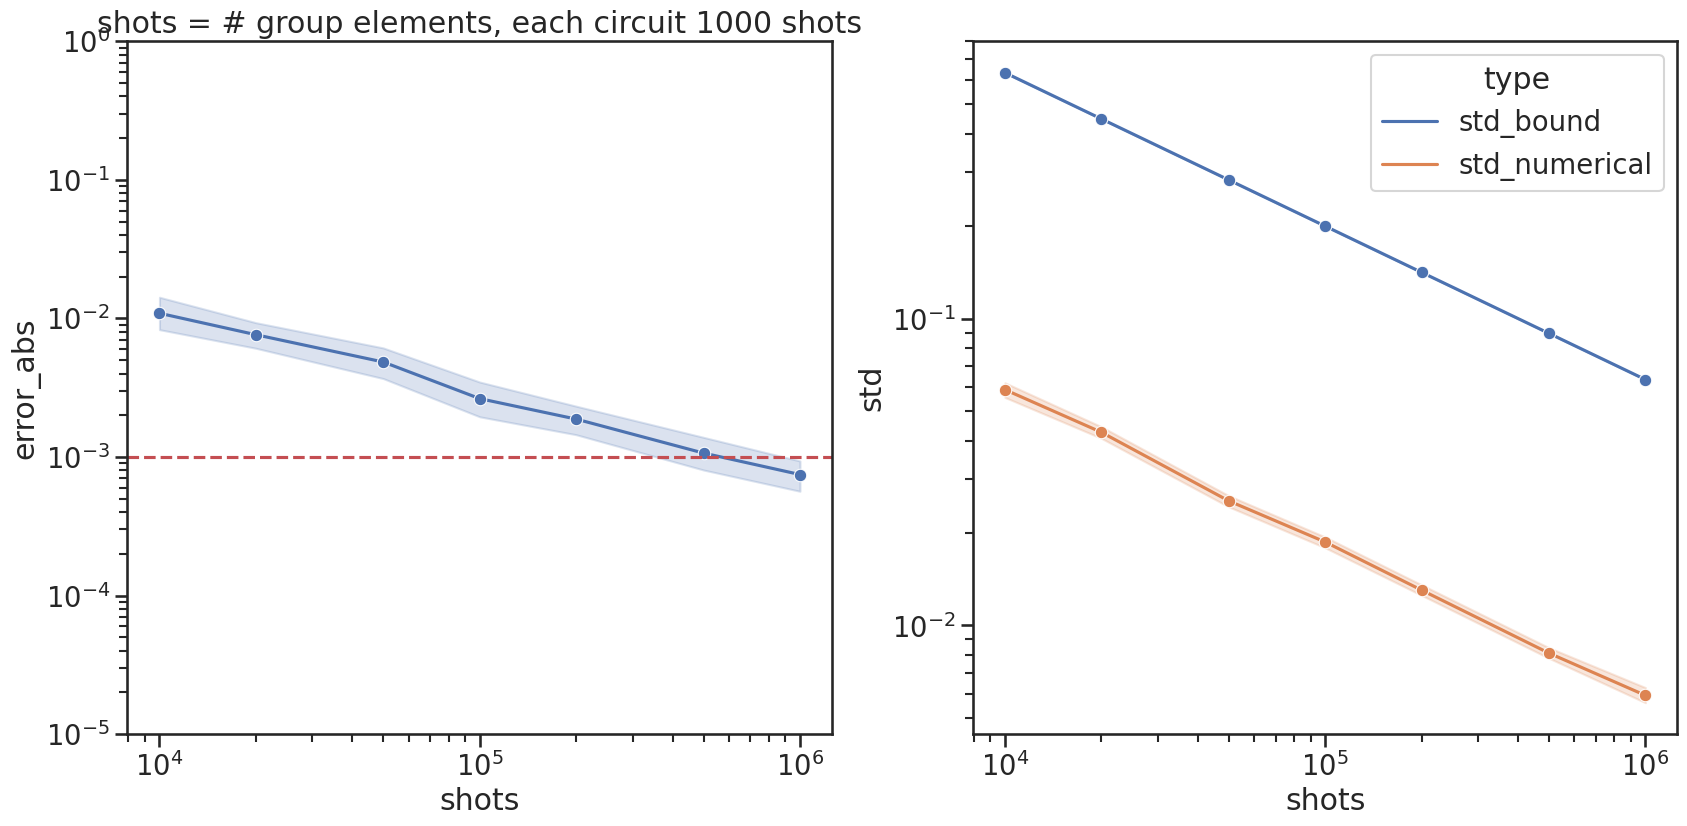

In [4]:
dff = df.dropna()
dff.drop(dff[np.abs(dff.energy) > 1e10].index, inplace=True)

sns.set_theme(context='talk', style="ticks", font_scale=1.2)
fig, (ax, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 9)
sns.lineplot(data=dff, x="shots", y="error_abs", ax=ax, marker='o')
ax.set_yscale('log')
ax.set_xscale('log')

ax.axhline(1e-3, label="chem. acc.", linestyle="--", color='r')
ax.set_ylim((1e-5, 1))

dfm = pd.melt(dff, id_vars=["shots", "sample"], value_vars=["std_bound", "std_numerical"], value_name="std", var_name="type")
sns.lineplot(data=dfm, x="shots", y="std", hue="type", ax=ax2, marker='o')
ax2.set_yscale('log')
ax2.set_xscale('log')

ax.set_title("shots = # group elements, each circuit 1000 shots")

plt.savefig("h4_matchgate_error.png")

In [5]:
df_exp = pd.read_hdf("/fs/home/cvsik/Projects/tailored_cc/qcqmc-recirq/h4_sto3g/h4_sto3g_experiment_data.h5", key="df")
df_exp['ngroup'] = df_exp.nsamp
df_exp['sample'] = df_exp["repeat"]
df_exp['Type'] = "Experiment"
df_exp["shots"] = df_exp.ngroup * 1000

dff['Type'] = "Simulation"

dfbig = pd.concat([df_exp, dff, df_single], ignore_index=True)
dfbig.drop(columns=['energy'], inplace=True)

/tmp/ipykernel_1233374/1324909843.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Type'] = "Simulation"


/fs/home/cvsik/miniforge3/envs/tcc/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


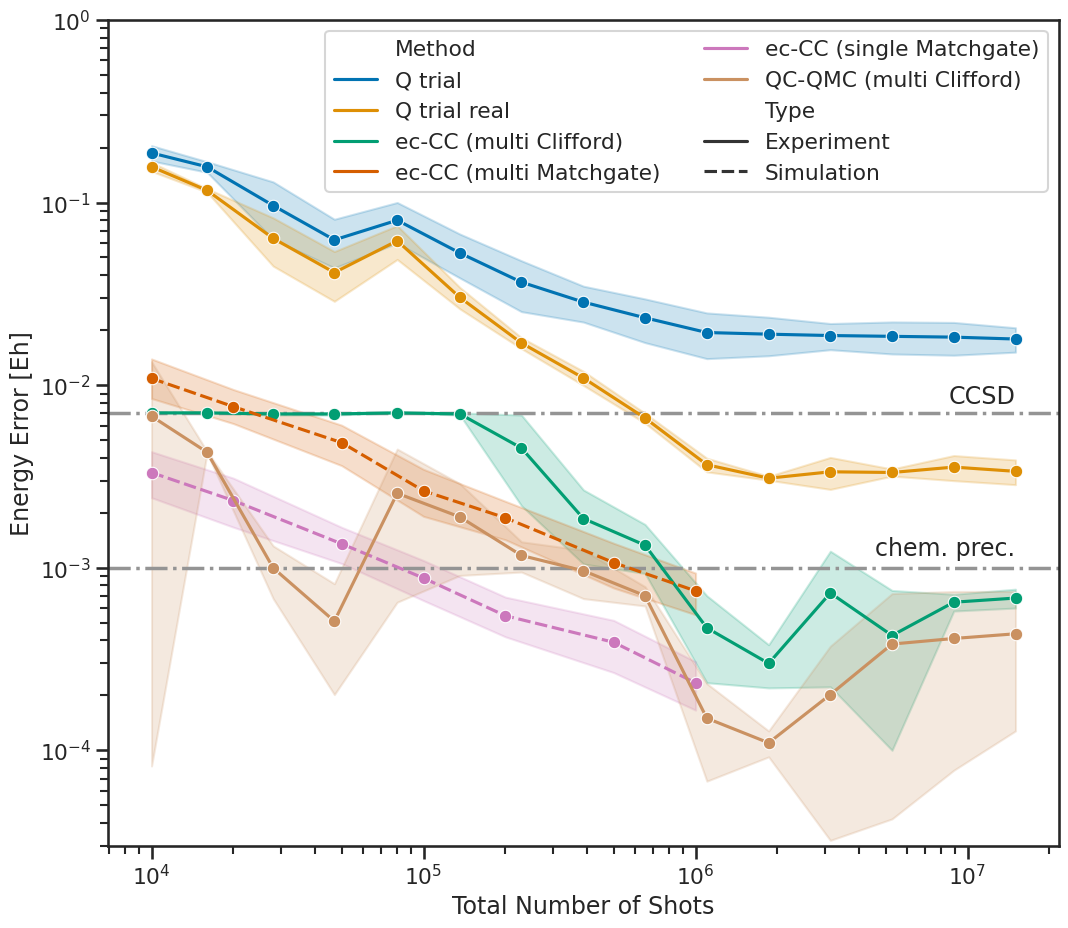

In [6]:
dfm = pd.melt(
    dfbig, id_vars=['sample', 'ngroup', 'Type', 'shots'], value_name="energy", value_vars=[
        'energy_fqe',
        'energy_fqe_real',
        # 'energy_tcc',
        'energy_ec',
        'energy_ec_mg',
        'energy_ec_mg_single',
        'energy_qcqmc',
    ], var_name="method"
)

ref_energy = np.unique(df_exp.energy_casci.values)
dfm['error'] = dfm.groupby('method')['energy'].transform(lambda x: np.abs(np.array(x) - ref_energy))
# # display(dfm)
# dfm.method = dfm.method.str.replace('energy_', '')

sns.set_theme(
    context="talk",
    # font_scale=1.5,
    font_scale=0.95,
    palette="colorblind", style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(11, 9.6)
# fig.set_size_inches(9.5, 8)

# ax.axhline(1e-3, label="chem. acc.", linestyle="-.", color=sns.color_palette("colorblind")[7], linewidth=1.5)
# ax.axhline(7.05e-3, label="CCSD", linestyle="-.", color=sns.color_palette("colorblind")[8], linewidth=1.5)
ax.axhline(1e-3, linestyle="-.", color=sns.color_palette("colorblind")[7], linewidth=2.5)
ax.axhline(7.05e-3, linestyle="-.", color=sns.color_palette("colorblind")[7], linewidth=2.5)


sns.lineplot(
    data=dfm, x="shots", y="error", hue="method", marker="o",
    # markersize=8,
    style="Type",
    # errorbar="bar",
    # linewidth=2.0,
    ax=ax, err_kws={"alpha": 0.20}
)
ax.set_yscale("log")
ax.set_xscale("log")
# ax.set_xlabel(r"$N_\mathrm{Group}$")
ax.set_xlabel("Total Number of Shots")
ax.set_ylabel("Energy Error [Eh]")

ax.set_ylim(3e-5, 1)
handles, labels = ax.get_legend_handles_labels()
sns.move_legend(obj=ax,
                loc="best",
                # loc="upper left",
                # bbox_to_anchor=(1.01, 1.0),
                ncol=2,
                title=None,
                # frameon=False,
                frameon=True,
                # labels=["chem. prec.", "CCSD", "Method", "Q trial", "Q trial real", "ec-CC Clifford", "ec-CC multi Matchgate", "ec-CC single Matchgate", "QC-QMC", "Type", "Experiment", "Simulation"],
                labels=["Method", "Q trial", "Q trial real", "ec-CC (multi Clifford)", "ec-CC (multi Matchgate)", "ec-CC (single Matchgate)", "QC-QMC (multi Clifford)", "Type", "Experiment", "Simulation"],
                # labels=["Q trial", "Q trial real", "ec-CC (multi Clifford)", "ec-CC (multi Matchgate)", "ec-CC (single Matchgate)", "QC-QMC (multi Clifford)", "Experiment", "Simulation"],
                # labels=labels,
                handles=handles,
)
ax.text(1.5e7, 7.5e-3, "CCSD", horizontalalignment='right',
        verticalalignment='bottom',)
ax.text(1.5e7, 1.1e-3, "chem. prec.", horizontalalignment='right',
        verticalalignment='bottom',)
plt.tight_layout()
plt.savefig("h4_all_methods_shadow.png", dpi=300)
plt.savefig("h4_all_methods_shadow.pdf", dpi=300)

In [35]:
groups = dfm.groupby("method")
dfm['error_mh'] = dfm.error / 1e-3

dfs = []
for name, idf in groups:
    # print(name)
    if not "_mg" in name:
        continue
    idf['energy_mean'] = idf.groupby('shots')['energy'].transform('mean')
    idf['error_mean'] = idf.groupby('shots')['error_mh'].transform('mean')
    idf = idf[['shots', 'sample', 'energy_mean', 'error_mean']]
    idf = idf.drop_duplicates(('energy_mean', 'error_mean'))
    idf = idf.dropna()
    idf['energy_with_error_fmt'] = idf.apply(
        lambda row: f"${row.energy_mean:.5f}~({row.error_mean:.2f})$",
        axis=1,
    )
    # display(idf.head())
    # idf = idf.pivot_table(index="nsamp", columns="repeat", values=["energy_with_error_fmt"])#.swaplevel(0, 1, 1).sort_index(axis=1)
    idf = idf[['shots', 'energy_with_error_fmt']]
    idf = idf.set_index("shots")
    
    dfs.append(idf.copy())
    # display(idf.head())

dfmerge = pd.concat(dfs, axis=1)


idf.to_latex(
    f"tables/h4_sto3g_{name}.tex",
    # columns=['energy_fqe', 'energy_fqe_real', 'energy_ec', 'energy_qcqmc'],
    # float_format="$%.5f$",
    # header=None,
    # longtable=True,
    column_format="cll"
)

energy_ec
energy_ec_mg


,shots,sample,energy_mean,error_mean,energy_with_error_fmt
1314,10000,1,-1.980289,10.889503,$-1.98029~(10.89)$
1374,20000,0,-1.976618,7.624369,$-1.97662~(7.62)$
1403,50000,0,-1.971604,4.843422,$-1.97160~(4.84)$
1432,100000,0,-1.969217,2.636843,$-1.96922~(2.64)$
1461,200000,0,-1.969652,1.876742,$-1.96965~(1.88)$


energy_ec_mg_single


,shots,sample,energy_mean,error_mean,energy_with_error_fmt
1752,10000,1,-1.969061,3.322306,$-1.96906~(3.32)$
1812,20000,0,-1.969897,2.333203,$-1.96990~(2.33)$
1841,50000,0,-1.969269,1.352150,$-1.96927~(1.35)$
1870,100000,0,-1.969331,0.877941,$-1.96933~(0.88)$
1899,200000,0,-1.969451,0.546008,$-1.96945~(0.55)$


energy_fqe
energy_fqe_real
energy_qcqmc


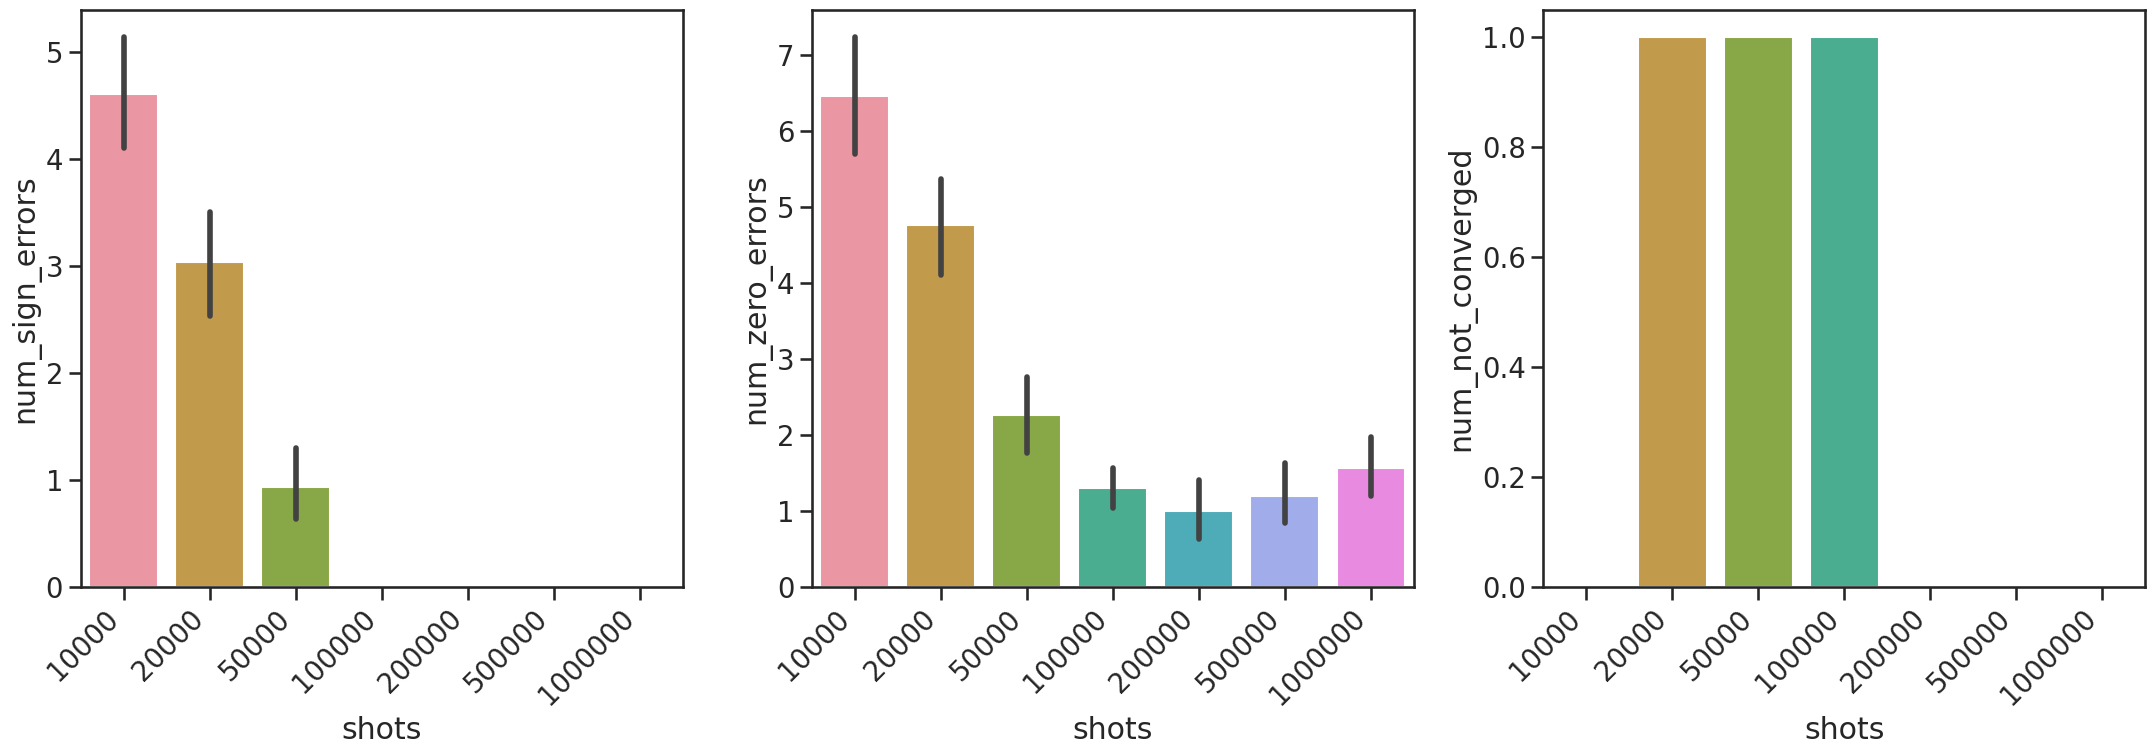

In [8]:
# df = df_single
sns.set_theme(context='talk', style="ticks", font_scale=1.2, palette="husl")
# df['samples_per_shots'] = df.groupby("shots")['sample'].transform('max')
# print(df.samples_per_shots)
# assert np.all(df.samples_per_shots) == 29
df['not_converged'] = df['energy'].isna()
df['num_not_converged'] = df.groupby("shots")['not_converged'].transform(sum)
# display(df)
fig, (ax, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(22, 8)

sns.barplot(data=df, x="shots", y="num_sign_errors", ax=ax)
sns.barplot(data=df, x="shots", y="num_not_converged", ax=ax3)
sns.barplot(data=df, x="shots", y="num_zero_errors", ax=ax2)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right');
ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=45, ha='right');

# sns.lineplot(data=df, x="shots", y="num_sign_errors", ax=ax, marker="o")
# sns.lineplot(data=df, x="shots", y="num_not_converged", ax=ax2, marker="o")
# ax.set_xscale("log")
# ax2.set_xscale("log")
plt.tight_layout()

In [9]:
groups = df.groupby("shots")

# for gname, dfs in groups:
#     x = (dfs.sign_errors + 0).sum()
#     mask = dfs.nonzero_mask.sum()
#     not_converged = dfs['energy'].isna().sum()
#     nwrong = x[mask].sum() / dfs.shape[0]
#     # print(nwrong)
#     x[~mask] = -1
#     fig, ax = plt.subplots(1, 1)
#     sns.heatmap(data=x, ax=ax, annot=True)
#     ax.set_title(f"shots={gname}, not converged={not_converged}")